In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'house-prices-advanced-regression-techniques:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F5407%2F868283%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241005%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241005T131621Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3d99e62a84af78177ba85bf312aee00c80ef28c32e5a5f480de6ea885cb2f9f6b0898cfbe98ecf2e9aa015abe5a3ed7e9b4422a5eda2eac18e1e3f80de1ace11f9cea29408b591353e2c9ab6cff6634860b05055796fe09ab22e760b66e679cffef8fe902bc9bc610e30555e3c0c333f3f4b1f6a0ed600d02859d763d6371edea9c0cd25bafc1e3e24f35e686e910acd2318956f69cb0e76368bbf0085a0d28d7a52524fb215ddf9df65fab538e0a252b35f359a9de7bb9d7aaa99727383f61a84f957fa0e3d6eaa30cfbec664f3c543a64ae75db618819f72f876dcea15889aafea804fbfa788ed63f7465311670483793ff600b33e1f1bf30a06e5d53d769f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 203809 bytes downloaded
Downloaded and uncompressed: house-prices-advanced-regression-techniques
Data source import complete.


# Import Dependencies

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder


# Data Collection and Processing

In [3]:
#Loading the data from csv file to pandas dataframe
houses_dataset = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')

In [4]:
#Inspecting the first 5 rows of dataframe
houses_dataset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#Checking the number of rows and columns
houses_dataset.shape

(1460, 81)

In [6]:
#Getting some information about the datset
houses_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
# Get all Numerical Data
numericals_columns = houses_dataset.select_dtypes(include=['float64', 'int64']).columns.tolist()  # Convert numerical columns to a list
numericals_columns.remove('OverallCond')
numericals_columns.remove('OverallQual')

# Print the list of numerical columns
print(numericals_columns)


['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [8]:
# Get all Categorical Data
categorical_columns = houses_dataset.select_dtypes(include=['object']).columns.tolist()  # Convert to a list
categorical_columns.append('OverallCond')  # Append the new column
categorical_columns.append('OverallQual')
print(categorical_columns)



['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'OverallCond', 'OverallQual']


In [9]:
# Ensure categorical + numerical columns equal total columns in dataset
print(len(categorical_columns)+len(numericals_columns))

81


##  Encoding categorical variables

In [10]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Loop through all categorical columns and apply Label Encoding
houses_dataset_labeled = houses_dataset
for col in categorical_columns:
    houses_dataset_labeled[col] = label_encoder.fit_transform(houses_dataset[col])

print(houses_dataset_labeled)

        Id  MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  \
0        1          60         3         65.0     8450       1      2   
1        2          20         3         80.0     9600       1      2   
2        3          60         3         68.0    11250       1      2   
3        4          70         3         60.0     9550       1      2   
4        5          60         3         84.0    14260       1      2   
...    ...         ...       ...          ...      ...     ...    ...   
1455  1456          60         3         62.0     7917       1      2   
1456  1457          20         3         85.0    13175       1      2   
1457  1458          70         3         66.0     9042       1      2   
1458  1459          20         3         68.0     9717       1      2   
1459  1460          20         3         75.0     9937       1      2   

      LotShape  LandContour  Utilities  ...  PoolArea  PoolQC  Fence  \
0            3            3          0  ...        

## Deal with the Nan Values

In [11]:
from sklearn.impute import SimpleImputer
# Imputer for categorical columns, filling with 'Missing' or most frequent category
imputer = SimpleImputer(strategy='constant')  # or strategy='constant', fill_value='Missing'

# Apply imputation
houses_dataset_labeled[categorical_columns] = imputer.fit_transform(houses_dataset_labeled[categorical_columns])
print(houses_dataset_labeled)

        Id  MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  \
0        1          60         3         65.0     8450       1      2   
1        2          20         3         80.0     9600       1      2   
2        3          60         3         68.0    11250       1      2   
3        4          70         3         60.0     9550       1      2   
4        5          60         3         84.0    14260       1      2   
...    ...         ...       ...          ...      ...     ...    ...   
1455  1456          60         3         62.0     7917       1      2   
1456  1457          20         3         85.0    13175       1      2   
1457  1458          70         3         66.0     9042       1      2   
1458  1459          20         3         68.0     9717       1      2   
1459  1460          20         3         75.0     9937       1      2   

      LotShape  LandContour  Utilities  ...  PoolArea  PoolQC  Fence  \
0            3            3          0  ...        

In [12]:
# Find rows with any NaN values
rows_with_nan = houses_dataset_labeled[houses_dataset_labeled.isna().any(axis=1)]
print(rows_with_nan)

        Id  MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  \
7        8          60         3          NaN    10382       1      2   
12      13          20         3          NaN    12968       1      2   
14      15          20         3          NaN    10920       1      2   
16      17          20         3          NaN    11241       1      2   
24      25          20         3          NaN     8246       1      2   
...    ...         ...       ...          ...      ...     ...    ...   
1443  1444          30         3          NaN     8854       1      2   
1446  1447          20         3          NaN    26142       1      2   
1449  1450         180         4         21.0     1533       1      2   
1450  1451          90         3         60.0     9000       1      2   
1453  1454          20         3         90.0    17217       1      2   

      LotShape  LandContour  Utilities  ...  PoolArea  PoolQC  Fence  \
7            0            3          0  ...        

In [13]:
# Imputer for numerical columns, using the mean
imputer = SimpleImputer(strategy='mean')
houses_dataset_labeled[numericals_columns] = imputer.fit_transform(houses_dataset_labeled[numericals_columns])

# Data Preparation For Training

In [14]:
X = houses_dataset_labeled.drop(['Id','SalePrice'],axis=1)
Y = houses_dataset_labeled['SalePrice']

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state=2)

# Model Training

## Linear Regression

In [16]:
#Loading Linear Regression
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train,Y_train)

LinearRegression()

In [17]:
#Prediction on Training Data
training_data_prediction = lin_reg_model.predict(X_train)

## Model Evaluation

In [18]:
# R squared error
error_score = metrics.r2_score(Y_train, training_data_prediction)
print("R squared Error : ", error_score)

R squared Error :  0.8555888145551529


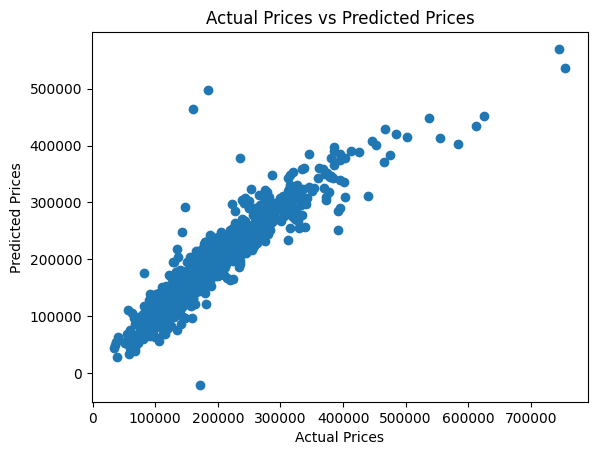

In [19]:
plt.scatter(Y_train, training_data_prediction)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual Prices vs Predicted Prices")
plt.show()

# Submission

In [20]:
import joblib

# Save the model to a file
joblib.dump(lin_reg_model, 'lin_reg_model.pkl')

['lin_reg_model.pkl']

In [21]:
def preprocess_data(data):
    houses_dataset = data
    #Getting some information about the datset
    houses_dataset.info()

    # Get all Numerical Data
    numericals_columns = houses_dataset.select_dtypes(include=['float64', 'int64']).columns.tolist()  # Convert numerical columns to a list
    numericals_columns.remove('OverallCond')
    numericals_columns.remove('OverallQual')

    # Get all Categorical Data
    categorical_columns = houses_dataset.select_dtypes(include=['object']).columns.tolist()  # Convert to a list
    categorical_columns.append('OverallCond')  # Append the new column
    categorical_columns.append('OverallQual')

    # Ensure categorical + numerical columns equal total columns in dataset
    print(len(categorical_columns)+len(numericals_columns))
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()
    # Loop through all categorical columns and apply Label Encoding
    houses_dataset_labeled = houses_dataset
    for col in categorical_columns:
        houses_dataset_labeled[col] = label_encoder.fit_transform(houses_dataset[col])

    # Imputer for categorical columns, filling with 'Missing' or most frequent category
    imputer = SimpleImputer(strategy='constant')  # or strategy='constant', fill_value='Missing'

    # Apply imputation
    houses_dataset_labeled[categorical_columns] = imputer.fit_transform(houses_dataset_labeled[categorical_columns])

    # Imputer for numerical columns, using the mean
    imputer = SimpleImputer(strategy='mean')
    houses_dataset_labeled[numericals_columns] = imputer.fit_transform(houses_dataset_labeled[numericals_columns])
    return houses_dataset_labeled

In [22]:
# Load your test data
test_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# Keep a copy of the Id column
ids = test_data['Id'].copy()  # Store the Ids

# Drop the Id column for preprocessing
X_test_submit = test_data.drop(columns=['Id'])  # Drop the Id column
X_test_submit = preprocess_data(X_test_submit)
print("Data preprocessing done")

# Predict SalePrice
predicted_prices = lin_reg_model.predict(X_test_submit)
print("SalePrice prediction done")

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'Id': ids,  # Use the Ids we stored earlier
    'SalePrice': predicted_prices  # Add the predicted SalePrice
})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

print("Submission file created successfully!")





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          107 non-null    object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil